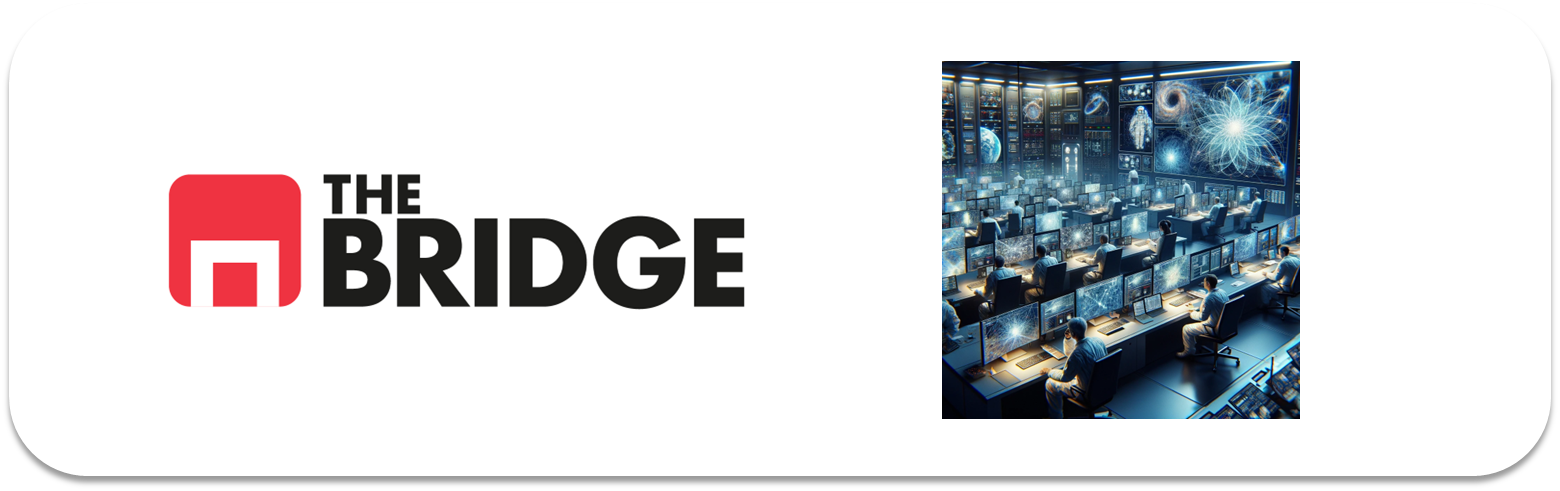

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import keras

import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder

from imageio import imread

from skimage.io import imread
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from time import time

from tensorflow.keras.applications import MobileNetV2
from time import time
import time

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
# Procedemos a importar los datos desde la carpeta de apples, es necesario observar la estructura de la carpeta
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [3]:

def read_data(directorio, reshape_dim=(75, 75)):
    X = []
    y = []
    if not os.path.exists(directorio):
        print(f"El directorio {directorio} no existe.")
        return np.array(X), np.array(y)

    for root, dirs, files in os.walk(directorio):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                file_path = os.path.join(root, file)
                try:
                    print(f"Leyendo el archivo: {file_path}")
                    image = imread(file_path)
                    image = cv2.resize(image, reshape_dim)
                    X.append(image)
                    label = os.path.basename(root)
                    y.append(label)
                except Exception as e:
                    print(f"Error al leer el archivo {file_path}: {e}")

    return np.array(X), np.array(y)

X_train, y_train = read_data(TRAIN_PATH, (224, 224))
X_test, y_test = read_data(TEST_PATH, (224, 224))

print(f"Número de imágenes de entrenamiento: {len(X_train)}")
print(f"Número de imágenes de prueba: {len(X_test)}")


Leyendo el archivo: ./data/seg_train/seg_train\buildings\0.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10006.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\1001.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10014.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10018.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10029.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10032.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10056.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\1009.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10113.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\1012.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10126.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10144.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10151.jpg
Leyendo el archivo: ./data/seg_train/seg_train\buildings\10161.jpg
Le

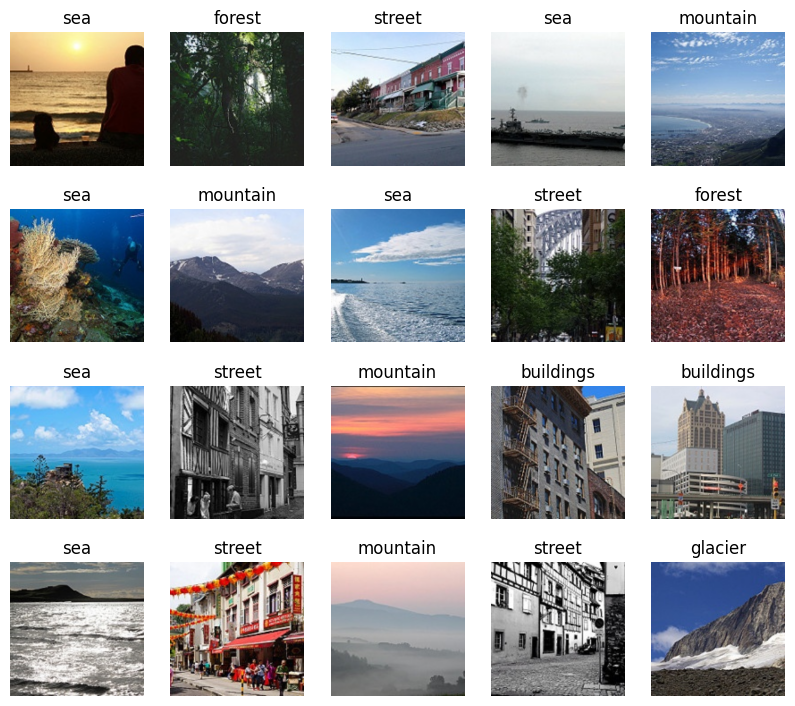

In [4]:
def show_images_batch(paisajes, names=[], n_cols=5, size_scale=2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje)
        plt.axis("off")
        if len(names):
            plt.title(names[index])
    plt.show()

indices = np.random.randint(0, len(X_train), 20)
show_images_batch(X_train[indices], names=y_train[indices], n_cols=5)

In [5]:
def normalize_data_in_batches(data, batch_size):
    num_samples = data.shape[0]
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        data[start:end] = data[start:end].astype('float32') / 255
    return data

X_train = normalize_data_in_batches(X_train, batch_size=100)
X_test = normalize_data_in_batches(X_test, batch_size=100)

In [6]:
from tensorflow.keras.utils import to_categorical

# Convertir etiquetas a índices
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Asegurar que las etiquetas sean categóricas (one-hot encoded)
y_train = to_categorical(y_train, num_classes=6)
y_test = to_categorical(y_test, num_classes=6)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [8]:
# Definir una función para preparar el modelo
def prepare_model(learning_rate=0.001):
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Añadir una capa densa adicional
    x = Dense(2048, activation='relu')(x)
    x = Dropout(rate=0.5)(x)
    predictions = Dense(6, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
model_final = prepare_model()


In [9]:
model_final.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,893,766 (18.67 MB)

 Trainable params: 2,635,782 (10.05 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# Definir early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Parámetros de entrenamiento
epochs = 10

# Entrenar el modelo
t_zero = time.time()
history_transfer = model_final.fit(X_train, y_train,
                                   epochs=epochs,
                                   callbacks=[early_stopping],
                                   validation_data=(X_val, y_val))

# Imprimir tiempo de entrenamiento
t_end = time.time()
print(f"Entrenamiento completado en {(t_end - t_zero)/60:.2f} minutos")

Epoch 1/10
 13/351 ━━━━━━━━━━━━━━━━━━━━ 11:03 2s/step - accuracy: 0.2062 - loss: 3.0514

In [ ]:
# Graficar la pérdida y la precisión
plt.figure(figsize=(12, 6))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_transfer.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento y la validación')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_transfer.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento y la validación')

plt.show()

In [ ]:

# Predecir etiquetas para el conjunto de prueba
y_pred = model_final.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Graficar la matriz de confusión
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Descongelar las capas superiores del modelo base
for layer in model_final.layers[-20:]:
    layer.trainable = True

# Compilar el modelo con una tasa de aprendizaje más baja
model_final.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo con fine-tuning
history_fine_tuning = model_final.fit(train_dataset,
                                      epochs=10,
                                      callbacks=[early_stopping],
                                      validation_data=test_dataset)

# Evaluar el modelo en el conjunto de test
test_loss, test_accuracy = model_final.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')

# Generar reporte de clasificación y matriz de confusión
Y_pred = model_final.predict(test_dataset)
y_pred = np.argmax(Y_pred, axis=1)
y_true = np.argmax(np.concatenate([y for x, y in test_dataset], axis=0), axis=1)
cm = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm, class_names=le.classes_)
print(classification_report(y_true, y_pred, target_names=le.classes_))
plot_training_history(history_fine_tuning)


In [ ]:
# Evaluar y obtener resultados de la red convolucional
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Red Convolucional - Loss en test: {cnn_test_loss:.4f}, Accuracy en test: {cnn_test_accuracy:.4f}")

# Hacer predicciones con el modelo de red convolucional
cnn_y_pred = cnn_model.predict(X_test)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis=1)
cnn_y_true = np.argmax(y_test, axis=1)

# Reporte de clasificación para la red convolucional
print("Reporte de clasificación para la Red Convolucional:\n")
print(classification_report(cnn_y_true, cnn_y_pred_classes))

# Matriz de confusión para la red convolucional
cnn_conf_matrix = confusion_matrix(cnn_y_true, cnn_y_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cnn_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Red Convolucional')
plt.show()

# Comparar los resultados de los dos modelos
print(f"Comparación de modelos:\n")
print(f"Modelo Fine-Tuned - Loss en test: {test_loss:.4f}, Accuracy en test: {test_accuracy:.4f}")
print(f"Red Convolucional - Loss en test: {cnn_test_loss:.4f}, Accuracy en test: {cnn_test_accuracy:.4f}")


In [ ]:
# Comparar los resultados de los dos modelos
print(f"Comparación de modelos:\n")
print(f"Modelo Fine-Tuned - Loss en test: {test_loss:.4f}, Accuracy en test: {test_accuracy:.4f}")
print(f"Red Convolucional - Loss en test: {cnn_test_loss:.4f}, Accuracy en test: {cnn_test_accuracy:.4f}")
